In [152]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#forked to learn the 'input
from subprocess import check_output
import subprocess
# print(check_output(["ls","input"],shell=True,stderr=subprocess.STDOUT,).decode("utf8"))
from sklearn.neural_network import MLPClassifier
import h5py
from scipy import sparse
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
print("Modules imported!")
print("Collecting Data...")
hf = h5py.File("input/cdk2.h5", "r")
ids = hf["chembl_id"] # the name of each molecules


Modules imported!


In [153]:
import warnings
warnings.filterwarnings('ignore')

In [154]:
ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]), shape=[len(hf["ap"]["indptr"]) - 1, 2039])
mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]), shape=[len(hf["mg"]["indptr"]) - 1, 2039])
tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]), shape=[len(hf["tt"]["indptr"]) - 1, 2039])
features = sparse.hstack([ap, mg, tt]).toarray() # the samples' features, each row is a sample, and each sample has 3*2039 features
labels = hf["label"] # the label of each molecule
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [155]:
labels

<HDF5 dataset "label": shape (1890,), type "<i8">

In [156]:
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix

def cosine(plays):
    normalized = normalize(plays)
    return normalized.dot(normalized.T)


def bhattacharya(plays):
    plays.data = np.sqrt(plays.data)
    return cosine(plays)


def ochiai(plays):
    plays = csr_matrix(plays)
    plays.data = np.ones(len(plays.data))
    return cosine(plays)


def bm25_weight(data, K1=1.2, B=0.8):
    """ Weighs each row of the matrix data by BM25 weighting """
    # calculate idf per term (user)
    N = float(data.shape[0])
    idf = np.log(N / (1 + np.bincount(data.col)))

    # calculate length_norm per document (artist)
    row_sums = np.squeeze(np.asarray(data.sum(1)))
    average_length = row_sums.sum() / N
    length_norm = (1.0 - B) + B * row_sums / average_length

    # weight matrix rows by bm25
    ret = coo_matrix(data)
    ret.data = ret.data * (K1 + 1.0) / (K1 * length_norm[ret.row] + ret.data) * idf[ret.col]
    return ret


def bm25(plays):
    plays = bm25_weight(plays)
    return plays.dot(plays.T)

def get_largest(row, N=10):
    if N >= row.nnz:
        best = zip(row.data, row.indices)
    else:
        ind = np.argpartition(row.data, -N)[-N:]
        best = zip(row.data[ind], row.indices[ind])
    return sorted(best, reverse=True)


def calculate_similar_artists(similarity, artists, artistid):
    neighbours = similarity[artistid]
    top = get_largest(neighbours)
    return [(artists[other], score, i) for i, (score, other) in enumerate(top)]



similarity = bm25(coo_matrix(features)).todense()

similarity

matrix([[1081.06364495,   90.18583029,   42.32094192, ...,   80.48898524,
           78.47186794,   82.09391297],
        [  90.18583029, 1008.21046951,  101.51321267, ...,  125.45888792,
          103.52277725,  146.84308866],
        [  42.32094192,  101.51321267, 1457.0755857 , ...,  137.73886646,
          458.1301387 ,  275.72155783],
        ...,
        [  80.48898524,  125.45888792,  137.73886646, ..., 3472.66003308,
          154.32427957,  182.3394268 ],
        [  78.47186794,  103.52277725,  458.1301387 , ...,  154.32427957,
         3038.38008702,  504.99802758],
        [  82.09391297,  146.84308866,  275.72155783, ...,  182.3394268 ,
          504.99802758, 1790.79614242]])

In [157]:
U, sigma, Vt = np.linalg.svd(similarity[:,:200], full_matrices=False)
sigma = np.diag(sigma)
print(U.shape,sigma.shape,Vt.shape)

(1890, 200) (200, 200) (200, 200)


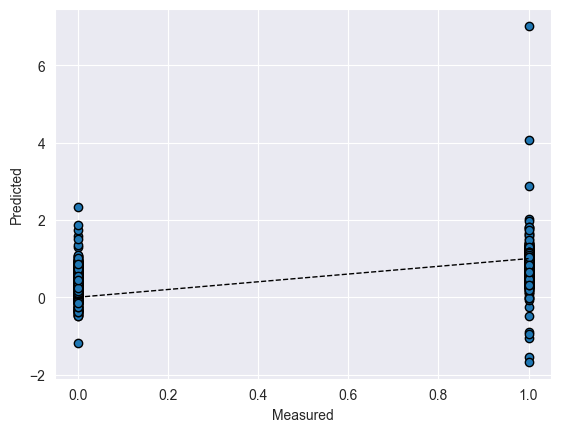

0.18798174172396198


In [158]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

nplabels = labels[:]

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, U, nplabels, cv=5)

fig, ax = plt.subplots()
ax.scatter(nplabels, predicted, edgecolors=(0, 0, 0))
ax.plot([nplabels.min(), nplabels.max()], [nplabels.min(), nplabels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

from sklearn.metrics import r2_score
print(r2_score(nplabels, predicted))

In [202]:
from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.preprocessing import MinMaxScaler

# import some data to play with
       # those ? converted to NAN are bothering me abit...

from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier, LarsCV

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,roc_curve,RocCurveDisplay, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

X = U
def rmsle(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted)-np.log1p(y_real), 2)))
def procenterror(y_predicted, y_real):
     return np.round( np.mean(np.abs(y_predicted-y_real) )/ np.mean(y_real) *100 ,1)


Y=labels[:]


names = [
         'ElasticNet',
         'SVC',
         'kSVC',
         'KNN',
         'DecisionTree',
         'RandomForestClassifier',
         'GridSearchCV',
         'HuberRegressor',
         'Ridge',
         'Lasso',
         'LassoCV',
         'Lars',
         'LarsCV',
         'BayesianRidge',
         'SGDClassifier',
         'RidgeClassifier',
         'LogisticRegression',
         'OrthogonalMatchingPursuit',
         ]

classifiers = [
    ElasticNetCV(cv=10, random_state=0),
    SVC(),
    SVC(kernel = 'rbf', random_state = 0),
    KNeighborsClassifier(n_neighbors = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200),
    GridSearchCV(SVC(),param_grid, refit = True, verbose = 1),
    HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,epsilon=2.95),
    Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True),
    Lasso(alpha=0.05),
    LassoCV(),
    Lars(n_nonzero_coefs=10),
    LarsCV(),
    BayesianRidge(),
    SGDClassifier(),
    RidgeClassifier(),
    LogisticRegression(),
    OrthogonalMatchingPursuit(),
]
correction= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]



def run_predictions(names,classifiers,correction):
    temp=zip(names,classifiers,correction)

    results = {}

    for name, clf,correct in temp:
        regr=clf.fit(X,Y)
        #print( name,'% errors', abs(regr.predict(X)+correct-Y).sum()/(Y.sum())*100)
        y_pred = regr.predict(X)
        print(name,'%error',procenterror(y_pred,Y),'rmsle',rmsle(y_pred,Y))


        # Confusion Matrix
        print(name,'Confusion Matrix')
        matrix = confusion_matrix(Y, np.round(regr.predict(X) ) )
        print( matrix )
        print('--'*40)

        # Classification Report
        print('Classification Report')
        report = classification_report(Y,np.round( regr.predict(X) ) )
        print(report)

        # Accuracy
        print('--'*40)
        logreg_accuracy = round(accuracy_score(Y, np.round( regr.predict(X) ) ) * 100,2)
        print('Accuracy', logreg_accuracy,'%')


        # Save it to results
        results[name] = {
            "report" : report,
            "matrix" : matrix,
            "logreg_accuracy" : logreg_accuracy,
            "y_pred" : y_pred,
        }

    return results


In [160]:
results = run_predictions(names,classifiers,correction)

ElasticNet %error 38.2 rmsle 0.23125134250382468
ElasticNet Confusion Matrix
[[ 414  205]
 [  55 1216]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       619
           1       0.86      0.96      0.90      1271

    accuracy                           0.86      1890
   macro avg       0.87      0.81      0.83      1890
weighted avg       0.86      0.86      0.86      1890

--------------------------------------------------------------------------------
Accuracy 86.24 %
SVC %error 11.5 rmsle 0.1926508754335712
SVC Confusion Matrix
[[ 494  125]
 [  21 1250]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       619
           1       0.91      0.98      0.94      1271

    accuracy

In [161]:
def roc_plot_from_res(results):
    fig, ax = plt.subplots(figsize=(10, 10))
    for name, feature in results.items():
        y_pred = feature["y_pred"]
        RocCurveDisplay.from_predictions(Y, y_pred, ax=ax, name='{} auc: {}'.format(name,feature["logreg_accuracy"]))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)

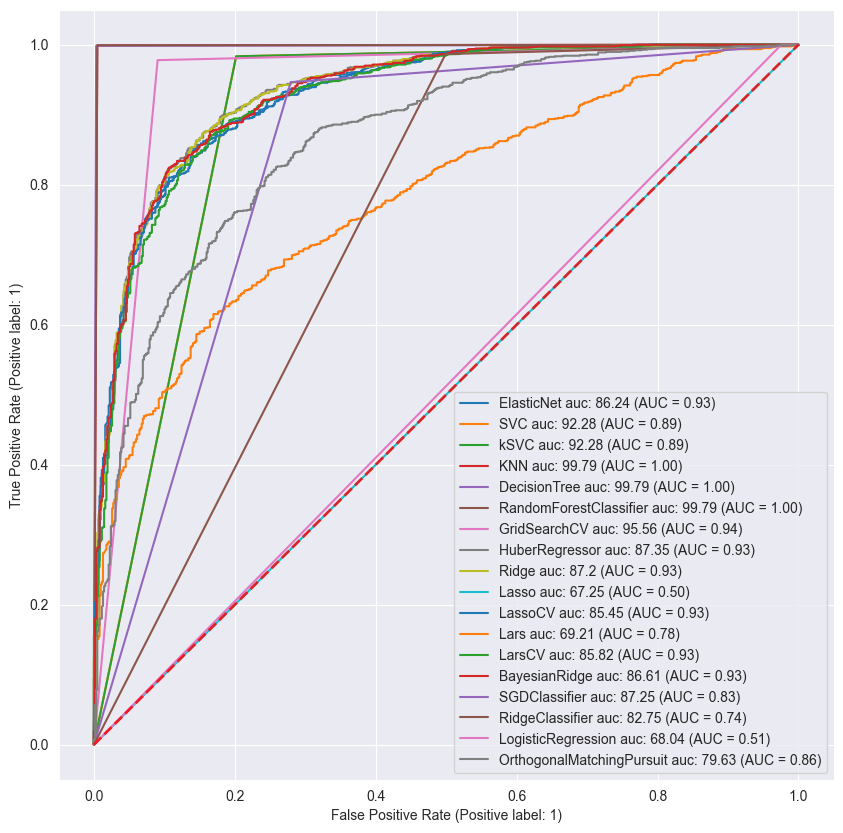

In [162]:
roc_plot_from_res(results)

In [163]:
treshold = 90
below_res = {}
above_res = {}

In [164]:
for name, feature in results.items():
    if feature["logreg_accuracy"] <= treshold:
        below_res[name] = feature
    else:
        above_res[name] = feature

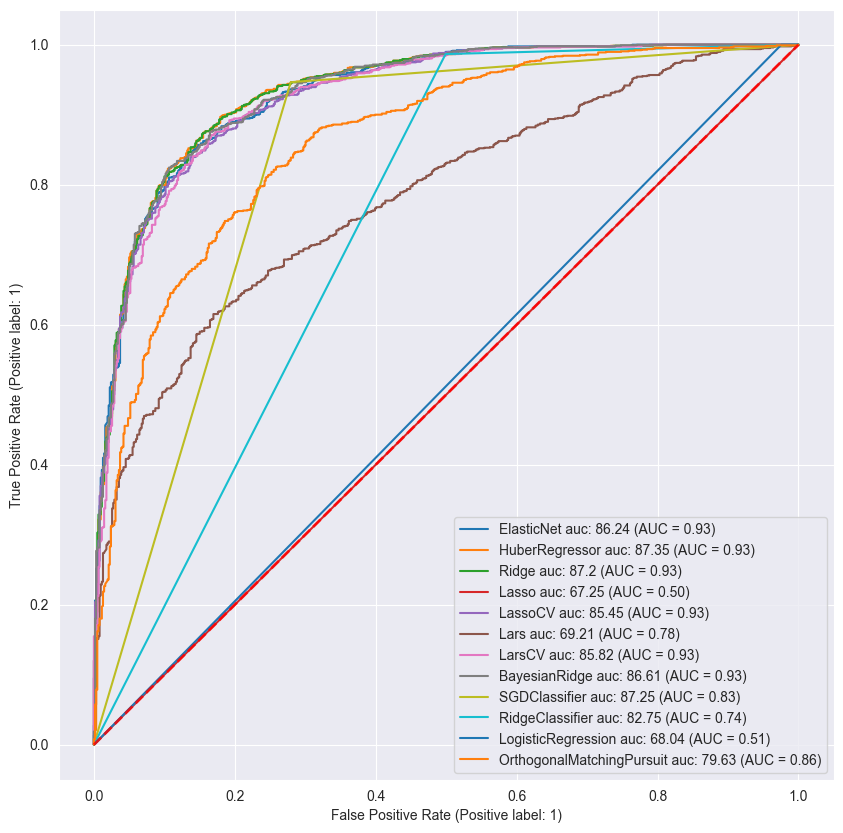

In [277]:
roc_plot_from_res(below_res)

In [166]:
print(below_res.keys())
print(below_res["Lasso"])

dict_keys(['ElasticNet', 'HuberRegressor', 'Ridge', 'Lasso', 'LassoCV', 'Lars', 'LarsCV', 'BayesianRidge', 'SGDClassifier', 'RidgeClassifier', 'LogisticRegression', 'OrthogonalMatchingPursuit'])
{'report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       619\n           1       0.67      1.00      0.80      1271\n\n    accuracy                           0.67      1890\n   macro avg       0.34      0.50      0.40      1890\nweighted avg       0.45      0.67      0.54      1890\n', 'matrix': array([[   0,  619],
       [   0, 1271]], dtype=int64), 'logreg_accuracy': 67.25, 'y_pred': array([0.67248677, 0.67248677, 0.67248677, ..., 0.67248677, 0.67248677,
       0.67248677])}


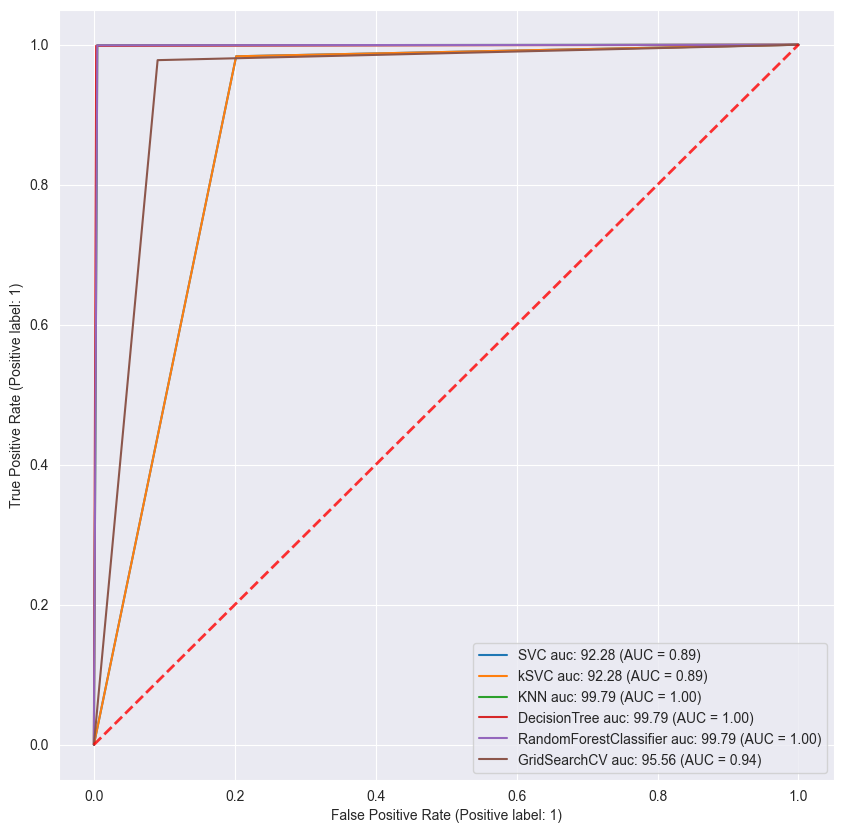

In [167]:
roc_plot_from_res(above_res)

In [168]:
def matrix_plot_from_res(results):
    for name, feature in results.items():
        fig, ax = plt.subplots()
        ax.legend = name
        fig.suptitle("Classifier: " + name)
        sns.heatmap(pd.DataFrame(feature["matrix"]), annot=True, cmap='Reds',ax=ax,fmt='g')
        plt.show()

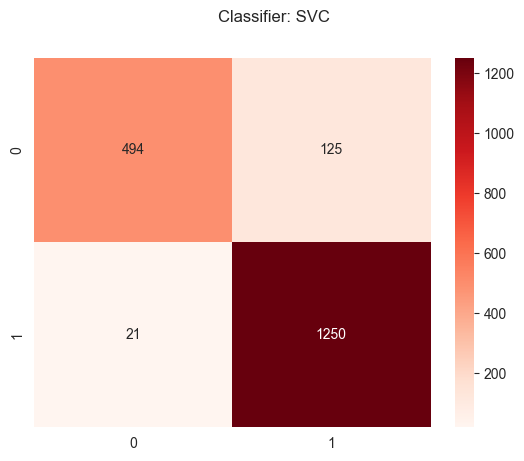

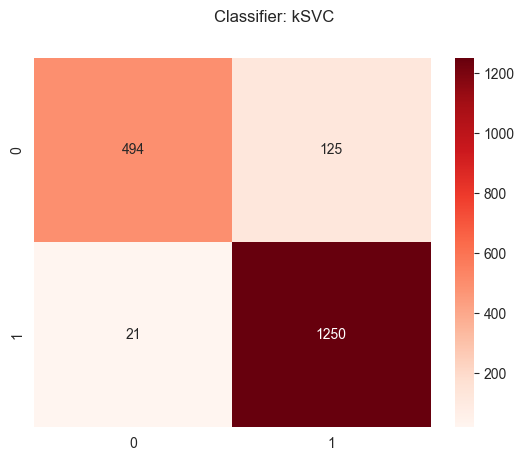

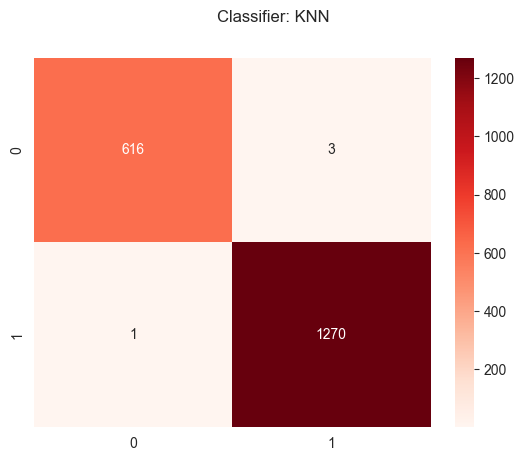

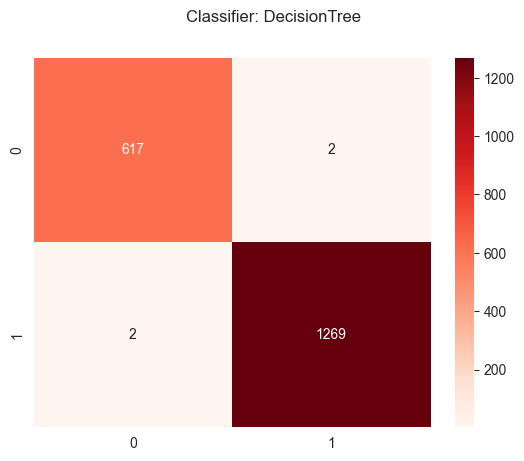

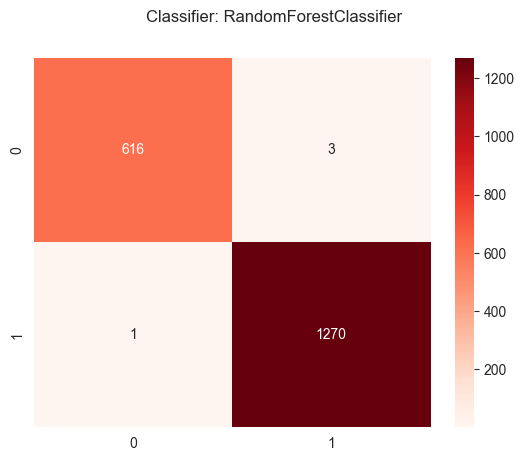

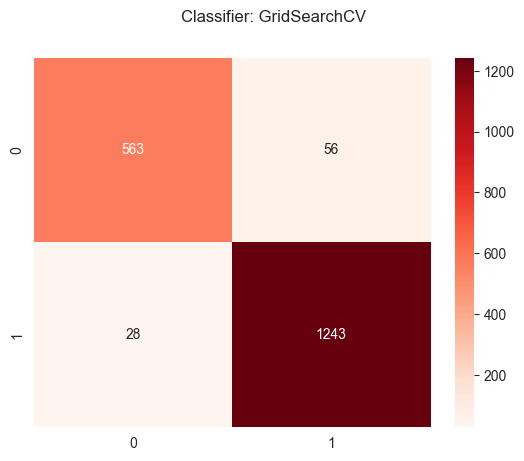

In [169]:
matrix_plot_from_res(above_res)

In [170]:
from sklearn import svm
from sklearn import metrics
from tqdm import tqdm

In [171]:
def SVM_model_predict_tune( x_train, x_test, y_train, y_test, kernel='rbf',
                           gamma='auto', C=1.0, cache_size=200, random_state=None,
                           tol=0.001, coef0=0.0 ):

    clf = svm.SVC( gamma=gamma, C=C, kernel=kernel, probability=True,
                  cache_size=cache_size, random_state=random_state, tol=tol, coef0=coef0 )
    clf.fit( x_train, y_train )

    y_pred = clf.predict_proba( x_test )

    fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred[:,1] )
    auc = metrics.auc( fpr, tpr )

    return auc

In [172]:

def hyper_parameters_gamma(gammas):
    auc_tune = np.empty( gammas.shape[0], dtype=float )
    for i in tqdm(range(gammas.shape[0])):
        auc_tune[i] = SVM_model_predict_tune( X, X, Y, Y, kernel='rbf', gamma=gammas[i] )
    gamma_best = gammas[ np.argmax( auc_tune, axis=0 ) ]

    fig = plt.figure( figsize=(6,4), dpi=100 )
    plt.title( 'Tuning the hyperparameters of SVM ', fontsize=20)
    plt.plot( gammas, auc_tune, label='AUC' )
    plt.ylabel( 'AUC value', fontsize = 15)
    plt.xlabel( 'Gamma parameter', fontsize = 15)
    plt.xscale( 'log' )
    plt.grid()
    plt.legend()
    plt.show()
    return gamma_best



100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


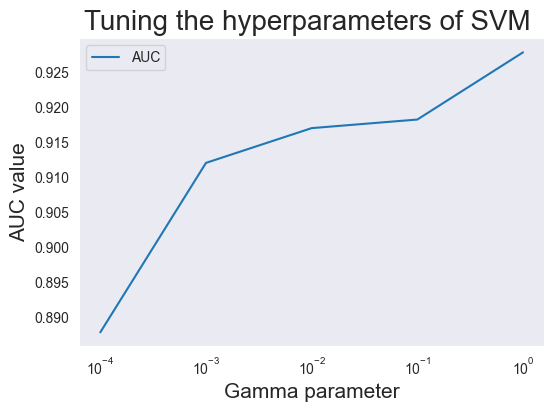

best gamma:  1.0


In [173]:
best_gamma = hyper_parameters_gamma(np.array(param_grid["gamma"]))
print("best gamma: ", best_gamma)

In [174]:
from sklearn.model_selection import RepeatedKFold,RepeatedStratifiedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0, 0.001, 100)
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
lasso.fit(X, Y)
print('alpha: %.2f' % lasso.alpha_)

alpha: 0.00


In [175]:
lasso_alphas

array([0.00000000e+00, 1.01010101e-05, 2.02020202e-05, 3.03030303e-05,
       4.04040404e-05, 5.05050505e-05, 6.06060606e-05, 7.07070707e-05,
       8.08080808e-05, 9.09090909e-05, 1.01010101e-04, 1.11111111e-04,
       1.21212121e-04, 1.31313131e-04, 1.41414141e-04, 1.51515152e-04,
       1.61616162e-04, 1.71717172e-04, 1.81818182e-04, 1.91919192e-04,
       2.02020202e-04, 2.12121212e-04, 2.22222222e-04, 2.32323232e-04,
       2.42424242e-04, 2.52525253e-04, 2.62626263e-04, 2.72727273e-04,
       2.82828283e-04, 2.92929293e-04, 3.03030303e-04, 3.13131313e-04,
       3.23232323e-04, 3.33333333e-04, 3.43434343e-04, 3.53535354e-04,
       3.63636364e-04, 3.73737374e-04, 3.83838384e-04, 3.93939394e-04,
       4.04040404e-04, 4.14141414e-04, 4.24242424e-04, 4.34343434e-04,
       4.44444444e-04, 4.54545455e-04, 4.64646465e-04, 4.74747475e-04,
       4.84848485e-04, 4.94949495e-04, 5.05050505e-04, 5.15151515e-04,
       5.25252525e-04, 5.35353535e-04, 5.45454545e-04, 5.55555556e-04,
      

In [176]:
# lasso = Lasso(0)
# lasso.fit(X, Y)
names = ["lasso","lasso_cv"]
classifiers = [Lasso(0.00001),Lasso(lasso.alpha_)]
correction = [0,0]

In [177]:
lasso_res = run_predictions(names,classifiers,correction)

lasso %error 35.7 rmsle 0.22331468164875198
lasso Confusion Matrix
[[ 462  157    0]
 [  83 1187    1]
 [   0    0    0]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.79       619
         1.0       0.88      0.93      0.91      1271
         2.0       0.00      0.00      0.00         0

    accuracy                           0.87      1890
   macro avg       0.58      0.56      0.57      1890
weighted avg       0.87      0.87      0.87      1890

--------------------------------------------------------------------------------
Accuracy 87.25 %
lasso_cv %error 37.9 rmsle 0.23054722555064408
lasso_cv Confusion Matrix
[[ 411  208    0]
 [  64 1206    1]
 [   0    0    0]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0

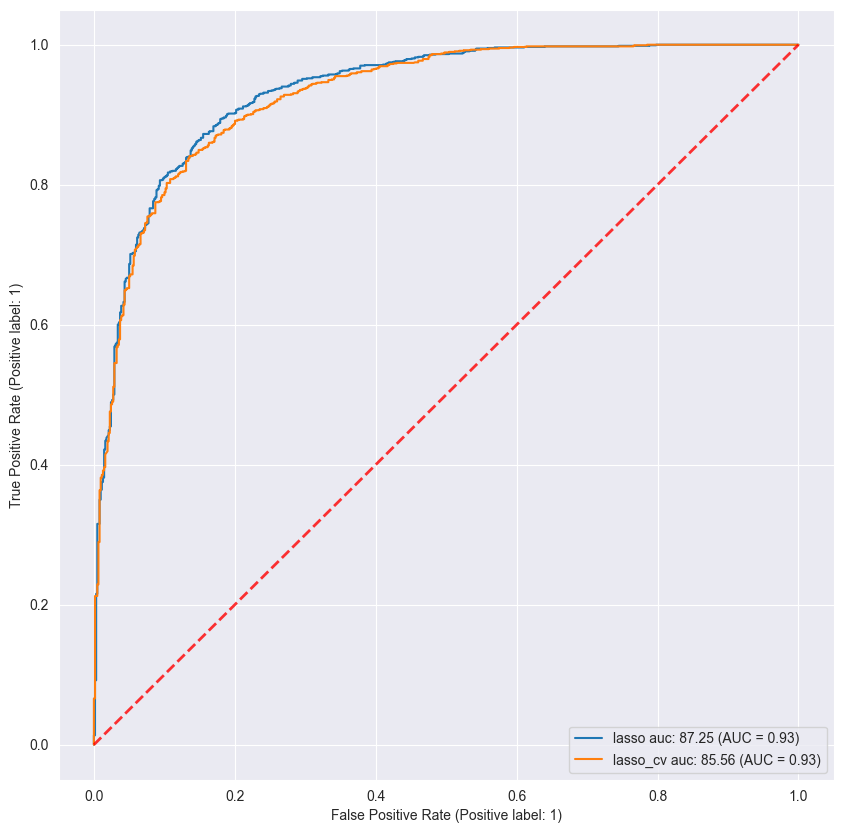

In [178]:
roc_plot_from_res(lasso_res)

In [225]:
def grid_search_optimizer(grid_search,X,Y):
    grid_result = grid_search.fit(X, Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_params_

In [226]:
def hyper_parameters_logistic_regression(X,Y):
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    # define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

    best_params = grid_search_optimizer(grid_search,X,Y)

    log_model = LogisticRegression(C=best_params["C"],penalty=best_params["penalty"],
                           solver=best_params["solver"])

    return logistic_params, log_model

In [227]:
logistic_params, log_model = hyper_parameters_logistic_regression(X,Y)

Best: 0.832628 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.821869 (0.024979) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.822046 (0.024910) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.822046 (0.024910) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.672487 (0.001587) wit

In [278]:
names = ["logmodel","hyper_tuned_log_model"]
classifiers = [LogisticRegression(),log_model]
correction = [0,0]

In [279]:
log_res = run_predictions(names,classifiers,correction)

logmodel %error 47.5 rmsle 0.3918438440230072
logmodel Confusion Matrix
[[  15  604]
 [   0 1271]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.02      0.05       619
           1       0.68      1.00      0.81      1271

    accuracy                           0.68      1890
   macro avg       0.84      0.51      0.43      1890
weighted avg       0.78      0.68      0.56      1890

--------------------------------------------------------------------------------
Accuracy 68.04 %
hyper_tuned_log_model %error 19.0 rmsle 0.2475158873146681
hyper_tuned_log_model Confusion Matrix
[[ 451  168]
 [  73 1198]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       619
           1       0.88      0.94   

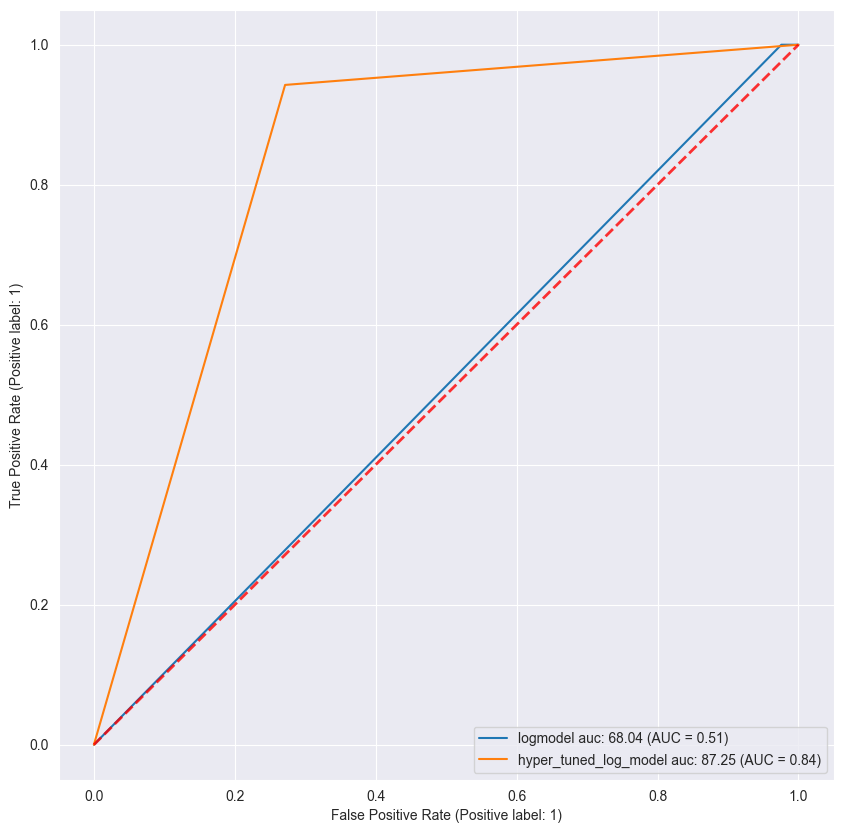

In [280]:
roc_plot_from_res(log_res)

In [231]:
def ridge_classifier_hyper(X,Y):
    # define models and parameters
    model = RidgeClassifier()
    alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    # define grid search
    grid = dict(alpha=alpha)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

    best_params = grid_search_optimizer(grid_search,X,Y)

    ridge_model = RidgeClassifier(best_params["alpha"])

    return ridge_model, best_params["alpha"]

In [232]:
ridge_model, alpha = ridge_classifier_hyper(X,Y)

Best: 0.833510 using {'alpha': 0.1}
0.833510 (0.024275) with: {'alpha': 0.1}
0.831922 (0.026620) with: {'alpha': 0.2}
0.828395 (0.025363) with: {'alpha': 0.3}
0.824339 (0.027336) with: {'alpha': 0.4}
0.818166 (0.025685) with: {'alpha': 0.5}
0.818519 (0.025673) with: {'alpha': 0.6}
0.814109 (0.024580) with: {'alpha': 0.7}
0.811993 (0.025143) with: {'alpha': 0.8}
0.809347 (0.024798) with: {'alpha': 0.9}
0.806702 (0.024351) with: {'alpha': 1.0}


ridge_model %error 25.6 rmsle 0.2878746076024993
ridge_model Confusion Matrix
[[ 310  309]
 [  17 1254]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.50      0.66       619
           1       0.80      0.99      0.88      1271

    accuracy                           0.83      1890
   macro avg       0.88      0.74      0.77      1890
weighted avg       0.85      0.83      0.81      1890

--------------------------------------------------------------------------------
Accuracy 82.75 %
hyper_tuned_ridge_model %error 19.7 rmsle 0.2520951922746962
hyper_tuned_ridge_model Confusion Matrix
[[ 429  190]
 [  60 1211]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       619
           1       0.86   

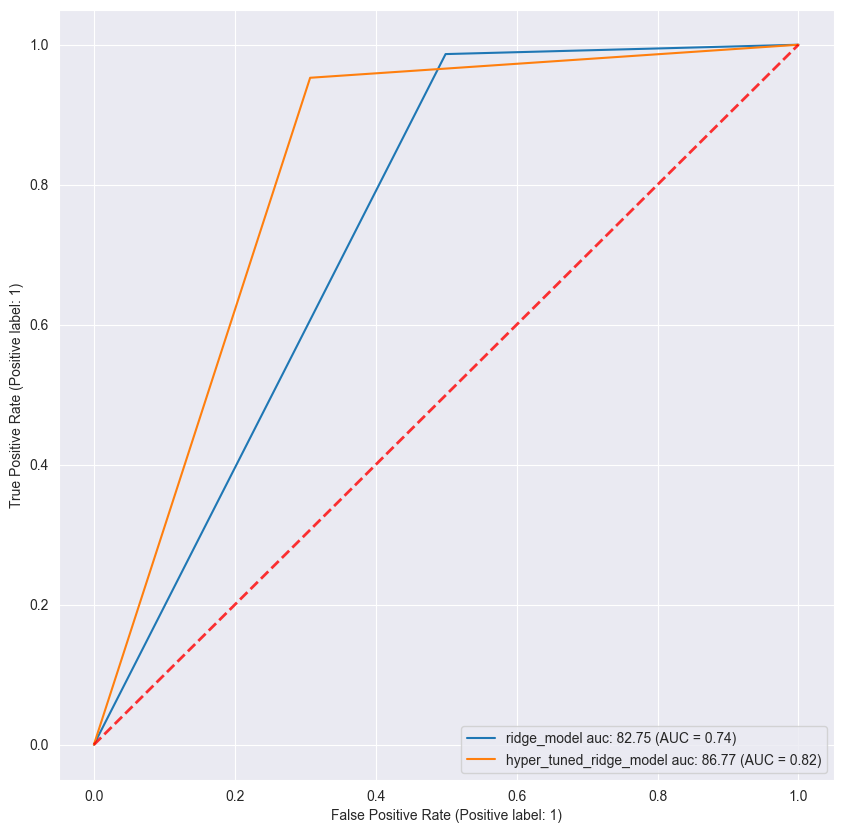

In [233]:
names = ["ridge_model", "hyper_tuned_ridge_model"]
classifiers = [RidgeClassifier(), ridge_model]
correction = [0, 0]
ridge_res = run_predictions(names, classifiers, correction)
roc_plot_from_res(ridge_res)

In [274]:

def sgd_classifier_hyper(X,Y):

    model = SGDClassifier()
    # define models and parameters
    grid = {
    # 'alpha': [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], # learning rate
    'alpha': np.linspace(1e-06,1e-04,10), # learning rate
    # 'n_iter': [1000], # number of epochs
    'loss': ['log_loss','hinge','squared_hinge','log'], # logistic regression,
    'penalty': ['l1','l2', 'elasticnet'],
    'n_jobs': [-1]
    }
    # paramGrid = ParameterGrid(grid)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)

    best_params = grid_search_optimizer(grid_search,X,Y)

    sgd_model = SGDClassifier(alpha=best_params["alpha"],n_jobs=best_params["n_jobs"],
                              loss=best_params["loss"],penalty=best_params["penalty"])

    return sgd_model, best_params

In [275]:
sgd_model, sgd_best = sgd_classifier_hyper(X,Y)

Best: 0.836332 using {'alpha': 8.900000000000001e-05, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.788183 (0.062611) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'l1'}
0.776190 (0.083949) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'l2'}
0.800353 (0.050950) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.821164 (0.030005) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.798765 (0.067447) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.790300 (0.062327) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.792063 (0.053317) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.775309 (0.066278) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.790300 (0.055551) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.804762 (0.050516) wi

sgd_model %error 20.1 rmsle 0.2551023983251597
sgd_model Confusion Matrix
[[ 421  198]
 [  58 1213]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       619
           1       0.86      0.95      0.90      1271

    accuracy                           0.86      1890
   macro avg       0.87      0.82      0.84      1890
weighted avg       0.87      0.86      0.86      1890

--------------------------------------------------------------------------------
Accuracy 86.46 %
hyper_tuned_sgd_model %error 18.7 rmsle 0.24597050766616568
hyper_tuned_sgd_model Confusion Matrix
[[ 445  174]
 [  64 1207]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       619
           1       0.87      0.95

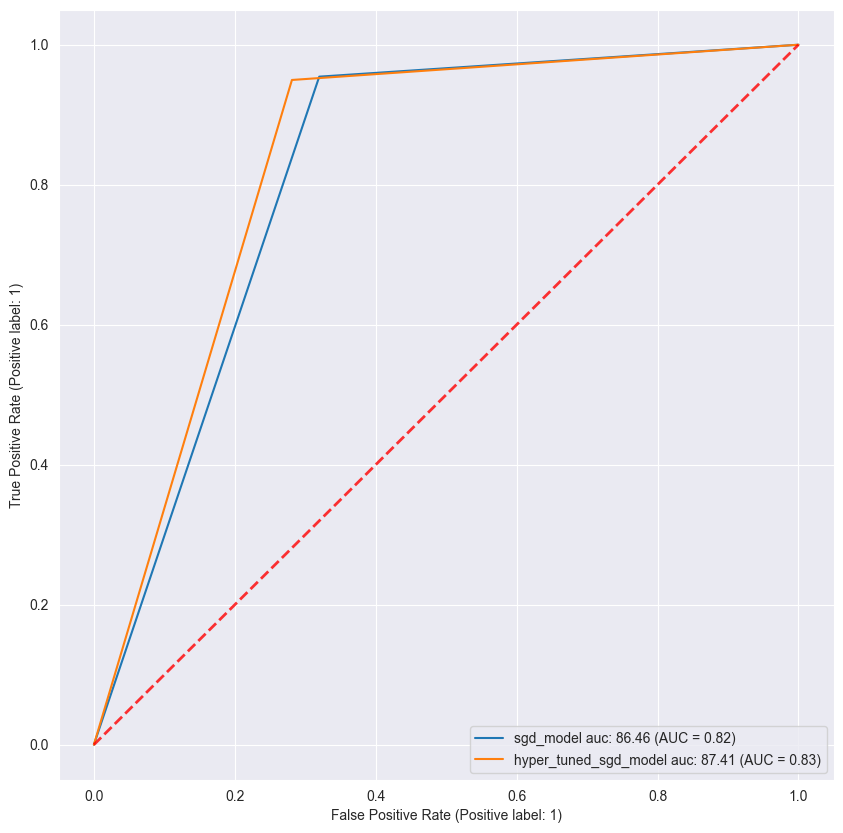

In [276]:
names = ["sgd_model", "hyper_tuned_sgd_model"]
classifiers = [SGDClassifier(), sgd_model]
correction = [0, 0]
sgd_res = run_predictions(names, classifiers, correction)
roc_plot_from_res(sgd_res)